In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
#from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression

In [2]:
location="D:\s_chernov\AnacondaProjects\SberHouse\Data\\"
tr=pd.read_csv(location+"train.csv",sep=',')
tst=pd.read_csv(location+"test.csv",sep=',')
macro=pd.read_csv(location+"sample_submission.csv",sep=',')
cheat=pd.read_csv(location+"sqprice.csv",sep=';')



In [3]:
from dateutil.parser import parse

dfDateTime=tr["timestamp"]
b=map(parse,dfDateTime)
year=map(lambda x:x.year,b)
month=map(lambda x:x.month,b)
day=map(lambda x:x.day,b)
tr['year']=year
tr['month']=month
tr['day']=day

dfDateTime=tst["timestamp"]
b=map(parse,dfDateTime)
year=map(lambda x:x.year,b)
month=map(lambda x:x.month,b)
day=map(lambda x:x.day,b)
tst['year']=year
tst['month']=month
tst['day']=day

In [4]:
#tr=pd.concat([tr, cheat], axis=1, join='outer')
#tst=pd.concat([tr, cheat], axis=1, join='outer')


tr=pd.merge(tr, cheat, how='left', on=['sub_area', 'sub_area'])
tst=pd.merge(tst, cheat, how='left', on=['sub_area', 'sub_area'])

tr.loc[:,'cheat']=tr.full_sq*tr.feb16
tst.loc[:,'cheat']=tst.full_sq*tst.feb16


In [5]:
tr=tr.drop('timestamp',axis=1)
tst=tst.drop('timestamp',axis=1)

In [6]:
#features by type
response='price_doc'

tr_type=(tr.dtypes==np.float64)|(tr.dtypes==np.int64)
dig_features=list(tr.loc[:,tr_type].columns)
dig_features.remove(response)
tr_type=(tr.dtypes==np.object)
obj_features=list(tr.loc[:,tr_type].columns)
tr2=tr.loc[tr.year==2015]


In [7]:
#___price and floor error

#print tst.loc[(tst.floor>tst.max_floor),['id','full_sq','floor','max_floor','sub_area']]

#_____price error
#print tr2.loc[(tr2.full_sq>180) &(tr2.price_doc<10000000),['id','full_sq','price_doc','sub_area']].index
tr2=tr2.drop( tr2.loc[(tr2.full_sq>180) &(tr2.price_doc<10000000)].index)

#___max_floor error
tr2=tr2.drop(tr2.loc[(tr2.floor>tr2.max_floor)].index)
correct=tst.loc[(tst.floor>tst.max_floor)].index
tst.loc[correct,'max_floor']=tst.floor[correct]+1
tr2=tr2.drop(tr2.loc[(tr2.num_room==0)].index)


In [8]:
#___square and num_room error
#print tr2.loc[(tr2.full_sq==64),['id','full_sq','num_room','price_doc','sub_area']]

tr2.loc[28867,'num_room']=1
tr2.loc[29172,'num_room']=2

tst.loc[464,'full_sq']=42
tst.loc[3500,'full_sq']=50
tst.loc[6350,'full_sq']=50
tst.loc[5383,'full_sq']=64
tst.loc[3174,'num_room']=1
tst.loc[6003,'num_room']=1
tst.loc[6181,'num_room']=2
tst.loc[7213,'num_room']=1
tst.loc[7313,'num_room']=1
tst.loc[1417,'num_room']=1
tst.loc[1429,'num_room']=1

#print tr2.loc[(tr2.full_sq/tr2.num_room<15),['id','full_sq','num_room','price_doc','sub_area']]
print tst.loc[(tst.full_sq/tst.num_room<15),['id','full_sq','num_room','sub_area']]


         id  full_sq  num_room            sub_area
2804  33278     14.8         1  Chertanovo Juzhnoe


In [9]:
#_________kitchen error

correct=tst.loc[(tst.kitch_sq/tst.full_sq>0.5)].index
tst.at[correct,'kitch_sq']=8

correct=tr2.loc[(tr.kitch_sq/tr.full_sq>0.5)].index
tr2.at[correct,'kitch_sq']=8

#print tst.loc[(tst.kitch_sq/tst.full_sq>0.5),['id','full_sq','kitch_sq','sub_area']]
#print tr2.loc[(tr2.kitch_sq/tr2.full_sq>0.5),['id','full_sq','kitch_sq','sub_area']]

#state error

tr2.at[tr2.state.isnull(),'state']=2
tst.at[tst.state.isnull(),'state']=2


In [10]:
#______last and first floor

tr2.loc[:,'first']=(tr2.floor==1).apply(int)
tr2.loc[:,'last']=(tr2.floor==tr2.max_floor).apply(int)
tst.loc[:,'first']=(tst.floor==1).apply(int)
tst.loc[:,'last']=(tst.floor==tst.max_floor).apply(int)


tr2.loc[:,'floor_low']=(tr2.floor<5).apply(int)
tst.loc[:,'floor_low']=(tst.floor<5).apply(int)

tr2.loc[:,'floor_5']=(tr2.floor==5).apply(int)
tst.loc[:,'floor_5']=(tst.floor==5).apply(int)

tr2.loc[:,'floor_9']=(tr2.floor==9).apply(int)
tst.loc[:,'floor_9']=(tst.floor==9).apply(int)

tr2.loc[:,'floor_12']=(tr2.floor==12).apply(int)
tst.loc[:,'floor_12']=(tst.floor==12).apply(int)

tr2.loc[:,'floor_13_18']=((tr2.max_floor>12) & (tr2.max_floor<=18)).apply(int)
tst.loc[:,'floor_13_18']=((tst.max_floor>12) & (tst.max_floor<=18)).apply(int)

tr2.loc[:,'floor_high']=(tr2.floor>18).apply(int)
tst.loc[:,'floor_high']=(tst.floor>15).apply(int)


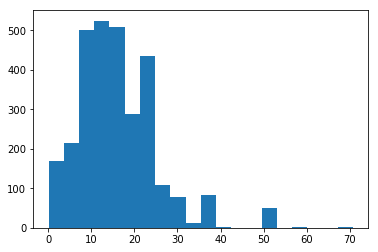

In [30]:


tr2.loc[:,'kremlin_near']=(tr2.kremlin_km<3).apply(int)
tst.loc[:,'kremlin_near']=(tst.kremlin_km<3).apply(int)

tr2.loc[:,'kremlin_1_5']=((tr2.kremlin_km>=1) & (tr2.kremlin_km<=5)).apply(int)
tst.loc[:,'kremlin_1_5']=((tst.kremlin_km>=1) & (tst.kremlin_km<=5)).apply(int)

tr2.loc[:,'kremlin_5_10']=((tr2.kremlin_km>5) & (tr2.kremlin_km<10)).apply(int)
tst.loc[:,'kremlin_5_10']=((tst.kremlin_km>5) & (tst.kremlin_km<10)).apply(int)


plt.hist(tr2.kremlin_km,20)
plt.show()

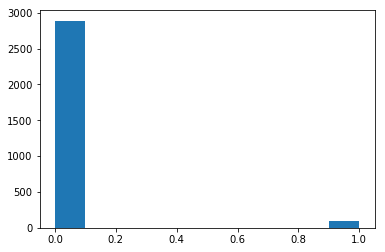

In [31]:
plt.hist(tr2.floor_high)
plt.show()

In [32]:
#ownership

tr2.loc[:,'own']=(tr2.product_type=='OwnerOccupier').apply(int)
tst.loc[:,'own']=(tst.product_type=='OwnerOccupier').apply(int)

#poselenie
#area_mo='Poselenie|Silino|Troickij okrug|Matushkino|Savelki|Severnoe|Vnukovo'
area_mo='Poselenie'


tr2.loc[:,'poselok']=tr2.sub_area.str.contains(area_mo).apply(int)
tst.loc[:,'poselok']=tst.sub_area.str.contains(area_mo).apply(int)

#radiation

tr2.loc[:,'radiate']=(tr2.radiation_raion=='yes').apply(int)
tst.loc[:,'radiate']=(tst.radiation_raion=='yes').apply(int)



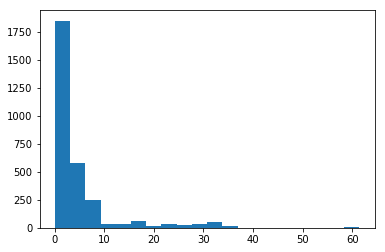

In [33]:
plt.hist((tr2.metro_min_avto),20)
plt.show()

#___metro features
tr2.loc[:,'metro_near']=(tr2.metro_min_avto<=3.4).apply(int)
tst.loc[:,'metro_near']=(tst.metro_min_avto<=3.4).apply(int)
tr2.loc[:,'metro_far']=(tr2.metro_min_avto>=20).apply(int)
tst.loc[:,'metro_far']=(tst.metro_min_avto>=20).apply(int)


In [38]:
from sklearn.model_selection import train_test_split

#features=['num_room','full_sq','kitch_sq','floor','floor_5','floor_high','state',
#          'kremlin_near','kremlin_3_5','kremlin_5_15','first','last',
#          'own','metro_near']

features=['num_room','full_sq','kitch_sq','floor','first','last',
          'floor_low','floor_5','floor_9','floor_12','floor_13_18','floor_high',
          'state','kremlin_near','kremlin_1_5','kremlin_5_10',
          'own','metro_near','metro_far','poselok','radiate','indust_part']



#features_mos=['num_room','full_sq','kitch_sq','floor','first','last',
#          'floor_low','floor_5','floor_9','floor_12','floor_13_18','floor_high',
#          'state','kremlin_near','kremlin_3_5','kremlin_5_15','indust_part',
#          'own','metro_near','metro_far','feb16','cheat']

features_mos=['num_room','full_sq','kitch_sq','floor','first','last',
          'floor_low','floor_5','floor_9','floor_12','floor_13_18','floor_high',
          'state','sadovoe_km','kremlin_1_5','indust_part',
          'own','metro_min_avto','feb16','cheat']



features_pos=['num_room','full_sq','first','last',
          'floor_12','mkad_km','metro_min_avto','indust_part']

np.random.seed(123)


tr_pos=tr2[tr2.poselok==1]
tr_mos=tr2[tr2.poselok==0]
tst_pos=tst[tst.poselok==1]
tst_mos=tst[tst.poselok==0]


X_train, X_test, y_train, y_test = train_test_split(tr2.loc[:,features], tr2.price_doc, test_size=0.33, random_state=42)
X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(tr_pos.loc[:,features_pos], tr_pos.price_doc, test_size=0.33, random_state=42)
X_train_mos, X_test_mos, y_train_mos, y_test_mos = train_test_split(tr_mos.loc[:,features_mos], tr_mos.price_doc, test_size=0.33, random_state=42)


In [39]:
#----all linear
fit1 = LinearRegression()
fit1 = fit1.fit(X_train, y_train)
print(zip(features,fit1.coef_))
#pred = fit2.predict(X_test)
fit1.score(X_test,y_test)

[('num_room', -126995.68398889345), ('full_sq', 159367.4064365424), ('kitch_sq', 71914.513644346065), ('floor', 27750.689235124737), ('first', -1252895.1751890976), ('last', -519630.87869510357), ('floor_low', -255265.51240518398), ('floor_5', -222975.65563606372), ('floor_9', -122142.86457745195), ('floor_12', 586744.73006148171), ('floor_13_18', -385295.32855105738), ('floor_high', 721182.2652428057), ('state', 824194.62436382566), ('kremlin_near', -1472539.3075717157), ('kremlin_1_5', 5741409.5557017513), ('kremlin_5_10', 1406775.4290156181), ('own', 880938.07661591202), ('metro_near', 1002830.4848786194), ('metro_far', -1232209.3720508623), ('poselok', -2204482.6486156993), ('radiate', 233075.55095686915), ('indust_part', -4003055.6870031548)]


0.58882669533957266

In [40]:
#poselok linear
fit2= LinearRegression()
fit2= fit2.fit(X_train_pos, y_train_pos)
print(zip(features_pos,fit2.coef_))
pred = fit2.predict(X_test_pos)
#print fit2.score(X_test_pos,y_test_pos)

pred[pred<900000]=900000

print r2_score (y_test_pos,pred)
print len(pred),min(pred),max(pred)
print len(y_test_pos),min(y_test_pos),max(y_test_pos)



[('num_room', 500781.51125017449), ('full_sq', 51928.150550338672), ('first', -142460.67546356164), ('last', -1463.1586222002525), ('floor_12', 32357.241971061183), ('mkad_km', -30712.731433985318), ('metro_min_avto', -84923.297251411102), ('indust_part', -7416456.031421761)]
0.814879259
260 900000.0 13518712.308
260 990000 15043290


In [41]:
#moscow linear
fit2= LinearRegression()
fit2= fit2.fit(X_train_mos, y_train_mos)
print(zip(features_mos,fit2.coef_))
pred = fit2.predict(X_test_mos)

#print fit2.score(X_test_mos,y_test_mos)
pred[pred<950000]=950000

print '________________'
print r2_score (y_test_mos,pred)
print len(pred),min(pred),max(pred)
print len(y_test_mos),min(y_test_mos),max(y_test_mos)



[('num_room', -441339.68918436917), ('full_sq', 148987.54403792907), ('kitch_sq', 40070.324268967284), ('floor', 68154.705883712013), ('first', -1459878.773360003), ('last', -771960.71569261537), ('floor_low', 254169.78116893099), ('floor_5', -335134.92994374922), ('floor_9', 162377.21441213845), ('floor_12', 655277.52588319837), ('floor_13_18', -66859.499787577821), ('floor_high', 1076679.7930764027), ('state', 774933.29641806148), ('sadovoe_km', -237318.99647236703), ('kremlin_1_5', 2929612.2115305783), ('indust_part', -3169568.8791118651), ('own', -216967.88988977094), ('metro_min_avto', 78253.770295169525), ('feb16', -29.30756119301077), ('cheat', 0.31868598307482898)]
________________
0.602455206229
724 950000.0 46386926.4503
724 976000 70000000


In [42]:
#one linear model

fit = LinearRegression()
X=tr2.loc[:,features]
Y=tr2.price_doc
fit = fit.fit(X, Y)

pred = fit.predict(tst.loc[:,features])
pred[pred<500000]=500000

In [43]:
#3 linear model for pos 
fit = LinearRegression()
X=tr2.loc[tr2.poselok==1,features_pos]
Y=tr2.loc[tr2.poselok==1,'price_doc']
fit = fit.fit(X, Y)

pred_pos = fit.predict(tst.loc[tst.poselok==1,features_pos])
pred_pos[pred_pos<900000]=900000

print len(pred_pos),min(pred_pos),max(pred_pos)
print len(Y),min(Y),max(Y)


1575 900000.0 13823013.2043
785 990000 15043290


In [44]:

#features_mos=['num_room','full_sq','kitch_sq','floor','first','last',
#          'floor_low','floor_5','floor_9','floor_12','floor_13_18','floor_high',
#          'state','kremlin_near','kremlin_3_5','kremlin_5_15',
#          'own','metro_near','metro_far','radiate','indust_part','feb16','cheat','sub_area']

#a=tst.loc[tst.poselok==0,:]


#a.loc[a.feb16.isnull(),'sub_area']

In [45]:
#3 linear model for pos and mos
fit = LinearRegression()
X=tr2.loc[tr2.poselok==0,features_mos]
Y=tr2.loc[tr2.poselok==0,'price_doc']
fit = fit.fit(X, Y)

pred_mos = fit.predict(tst.loc[tst.poselok==0,features_mos])
pred_mos[pred_mos<900000]=900000
print len(pred_mos),min(pred_mos),max(pred_mos)



6087 900000.0 90529294.1698


In [46]:
res1=pd.DataFrame({'id':tst.loc[tst.poselok==1,'id'],'price_doc':(pred_pos)})
#print res1.describe()

res2=pd.DataFrame({'id':tst.loc[tst.poselok==0,'id'],'price_doc':(pred_mos)})
#print res2.describe()
res=pd.concat([res1,res2])
del res1,res2

In [47]:
#pd.DataFrame({'id':tst.id,'price_doc':(pred)}).to_csv(location+'submission.csv',sep=',',index=False)
res.to_csv(location+'submission2.csv',sep=',',index=False)


In [48]:
np.random.seed(123)
